In [ ]:
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from math import sqrt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from ExlossUnivariate import ExlossUnivariate
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def init_lstm_weights(m):
    if isinstance(m, torch.nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                torch.nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                torch.nn.init.orthogonal_(param.data)

In [ ]:
# ==== Load Data ====

window_size = 30
window_step = 10
num_stations = 290

X = np.load(f"X-size{window_size}-step{window_step}-station{num_stations}.npy")  # shape: (n_samples, seq_len, n_features)
Y = np.load(f"Y-size{window_size}-step{window_step}-station{num_stations}.npy")  # shape: (n_samples, output_dim) or (n_samples, seq_len, output_dim)

In [ ]:
# ==== Data parameters ====

batch_size = 2**8
val_size = 0.2

In [ ]:
# ==== Split into train and validation sets ====

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=val_size, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
Y_val = torch.tensor(Y_val, dtype=torch.float32)

In [ ]:
# ==== Wrap into a dataset and dataloader ====
dataset_train = TensorDataset(X_train, Y_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) # must shuffle
dataset_val = TensorDataset(X_val, Y_val)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

In [13]:
# ==== Define Model ====
class SimpleLSTM(nn.Module):
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.hidden_size = hidden_size

    def forward(self, x):
        # access dimension data
        # x: (batch, seq_len, input_size)
        batch_size, sequence_length, num_features = x.shape
        # all timesteps
        out, _ = self.lstm(x)
        out = self.fc(out.contiguous().view(-1, self.hidden_size))
        out = out.view(batch_size, sequence_length, -1)
        out = out.squeeze(-1)
        return out

### Quant model

In [ ]:
# ==== Hyperparameters ====

num_epochs = 1
hidden_size = 2**5
num_layers = 1

In [ ]:
# ==== Determine model dimensions from data ====
input_size = X.shape[2]
output_size = Y.shape[1] if Y.ndim == 2 else Y.shape[2]

# ==== Initialize Model, Loss Function, Optimizer ====
model = SimpleLSTM(input_size, hidden_size, num_layers)
model = model.to(device)
criterion = ExlossUnivariate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
if_initialize = True
if if_initialize:
    model.apply(init_lstm_weights)
model

In [ ]:
# ==== Training Loop ====
n_epochs = num_epochs
n_epochs = 4

for epoch in range(n_epochs):

    # training
    model.train()
    running_loss_train = 0.0
    for xb, yb in dataloader_train:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item() * xb.size(0)
    epoch_loss_train = running_loss_train / len(dataset_train)

    # validation
    model.eval()
    running_loss_val = 0.0
    for xb, yb in dataloader_val:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        running_loss_val += loss.item() * xb.size(0)
    epoch_loss_val = running_loss_val / len(dataset_val)

    # Print losses over time
    print(f"Epoch {epoch + 1}/{n_epochs}, Training Loss: {epoch_loss_train:.4f}, Validation Loss: {epoch_loss_val:.4f}")

Epoch 1/4, Loss: 0.1592
Epoch 2/4, Loss: 0.1219
Epoch 3/4, Loss: 0.1113
Epoch 4/4, Loss: 0.1048


In [20]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(name, param.grad.abs().mean(), param.grad.abs().max())

lstm.weight_ih_l0 tensor(0.0010, device='cuda:0') tensor(0.0262, device='cuda:0')
lstm.weight_hh_l0 tensor(0.0003, device='cuda:0') tensor(0.0043, device='cuda:0')
lstm.bias_ih_l0 tensor(0.0008, device='cuda:0') tensor(0.0076, device='cuda:0')
lstm.bias_hh_l0 tensor(0.0008, device='cuda:0') tensor(0.0076, device='cuda:0')
fc.weight tensor(0.0026, device='cuda:0') tensor(0.0081, device='cuda:0')
fc.bias tensor(0.0052, device='cuda:0') tensor(0.0052, device='cuda:0')


### Plotting

In [21]:
a = preds.detach().cpu()
b = yb.detach().cpu()

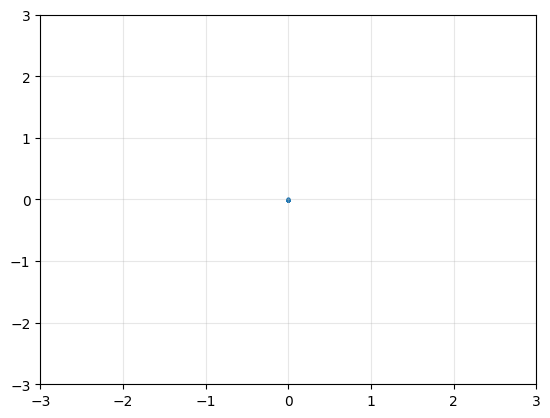

In [33]:
idx = 20

plt.scatter(b[idx,:], a[idx,:],s=3)
plt.xlim(-3,3)
plt.ylim(-3,3)

plt.grid(alpha=0.3)

# # diagonal line
# # Define a range of x-values.
# u = np.linspace(-3, 3, 100)
# # Set the y-values to be equal to the x-values.
# v = u
# # Create the plot.
# plt.plot(u, v, color='k')
# plt.xlabel('True value')
# plt.ylabel('Predicted value')


### All results

In [18]:
scaler_filename = 'standard_scaler.joblib'
loaded_scaler = joblib.load(scaler_filename)

In [173]:
# put on gpu
Xg = X.to(device)
Yg = Y.to(device)
Yhat = model(Xg)

In [174]:
# take off of gpu
Xg = Xg.detach().cpu()
Yg = Yg.detach().cpu()
Yhat = Yhat.detach().cpu()

In [175]:
# convert to numpy
Xg = Xg.numpy()
Yg = Yg.numpy()
Yhat = Yhat.numpy()

In [176]:
# reshape array dimensions
YXg = np.concatenate((Yg[:,:,np.newaxis],Xg),axis=-1)
YXhat = np.concatenate((Yhat[:,:,np.newaxis],Xg),axis=-1)
YXg = YXg.reshape(-1,YXg.shape[2],)
YXhat = YXhat.reshape(-1,YXhat.shape[2],)

In [177]:
# undo the standard scaler
YXg_unscaled = loaded_scaler.inverse_transform(YXg)
YXhat_unscaled = loaded_scaler.inverse_transform(YXhat)

In [178]:
# get the y data only
Yg_unscaled = YXg_unscaled[:,0]
Yhat_unscaled = YXhat_unscaled[:,0]

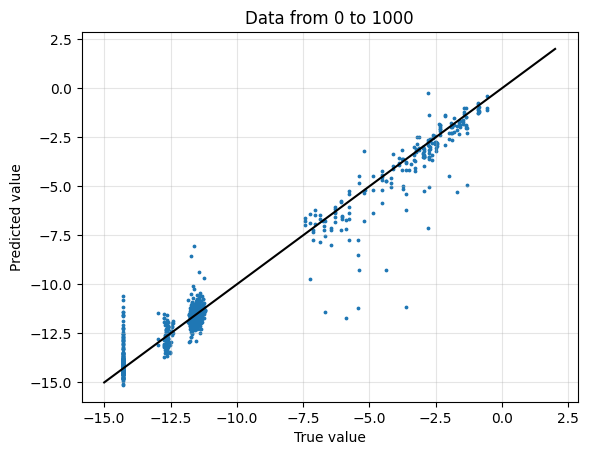

In [179]:
idx1 = 0
idx2 = 1000
plt.scatter(Yg_unscaled[idx1:idx2],
            Yhat_unscaled[idx1:idx2],
            s=3,
)

# Define a range of x-values.
u = np.linspace(-15, 2, 200)
# Set the y-values to be equal to the x-values.
v = u
# Create the plot.
plt.plot(u, v, color='k')
plt.xlabel('True value')
plt.ylabel('Predicted value')

plt.title(f'Data from {idx1} to {idx2}')

plt.grid(alpha=0.33)

In [123]:
def kge(Y, Yhat):
    '''
    Compute Kling-Gupta efficiency

    Parameters
    ----------
    Y : true values vector
    Yhat : predicted values vector

    Return
    ------
    float
    '''
    R = pearsonr(Y, Yhat).statistic
    Y_std = np.std(Y)
    Yhat_std = np.std(Yhat)
    Y_mu = np.mean(Y)
    Yhat_mu = np.mean(Yhat)
    beta = Yhat_mu / Y_mu
    gama = Yhat_std / Y_std
    print(f'Pearson R = {R}, beta = {beta}, gamma = {gama}')
    return 1 - sqrt((R-1)**2 + (beta - 1)**2 + (gama - 1)**2)

In [180]:
# unscaled version at log10
print('Log 10 scale')
kappa = kge(Yg_unscaled,Yhat_unscaled)
print(f'KGE = {kappa}')

Log 10 scale
Pearson R = 0.9843769073486328, beta = 1.0010871887207031, gamma = 0.9818117022514343
KGE = 0.9759983928553873


In [181]:
# original scale (undo the log10)
print('Original scale')
Yg_10 = 10 ** Yg_unscaled
Yhat_10 = 10 ** Yhat_unscaled
kappa = kge(Yg_10, Yhat_10)
print(f'KGE = {kappa}')

Original scale
Pearson R = 0.6254482865333557, beta = 1.2184311151504517, gamma = 2.101107120513916
KGE = -0.18340106062874617


In [182]:
# filter out extremes
print('Original scale (filter out extremes)')
extremely_high = 0.5
extremely_low = 1e-16
Yhat_filt = Yhat_10[(Yhat_10 < extremely_high) & (Yhat_10 > extremely_low)]
Yg_filt = Yg_10[(Yhat_10 < extremely_high) & (Yhat_10 > extremely_low)]
kappa = kge(Yg_filt, Yhat_filt)
print(f'KGE = {kappa}')

Original scale (filter out extremes)
Pearson R = 0.775825023651123, beta = 0.9723242521286011, gamma = 1.0394811630249023
KGE = 0.7706986104444591


In [183]:
qs = [0.001,0.01,0.98,0.99,0.995,0.999]
print('Prediction extremes')
print(np.quantile(Yhat_10,qs))
print('Real extremes')
print(np.quantile(Yg_10,qs))

Prediction extremes
[4.64450506e-16 1.39953466e-15 1.81089998e-02 5.79841270e-02
 1.20372096e-01 4.07872021e-01]
Real extremes
[4.99999822e-15 4.99999822e-15 2.27000229e-02 6.17000759e-02
 1.18999988e-01 2.83999979e-01]


### Testing

In [184]:
W = torch.load(f"testing/X-size{window_size}-step{window_step}-station{num_stations}.pt")  # shape: (n_samples, seq_len, n_features)
Z = torch.load(f"testing/Y-size{window_size}-step{window_step}-station{num_stations}.pt")  # shape: (n_samples, output_dim) or (n_samples, seq_len, output_dim)

In [185]:
# put on gpu
Wg = W.to(device)
Zhat = model(Wg)
# take off of gpu
Wg = Wg.detach().cpu()
Zg = Z
Zhat = Zhat.detach().cpu()
# convert to numpy
Wg = Wg.numpy()
Zg = Zg.numpy()
Zhat = Zhat.numpy()
# reshape array dimensions
ZWg = np.concatenate((Zg[:,:,np.newaxis],Wg),axis=-1)
ZWhat = np.concatenate((Zhat[:,:,np.newaxis],Wg),axis=-1)
ZWg = ZWg.reshape(-1,ZWg.shape[2],)
ZWhat = ZWhat.reshape(-1,ZWhat.shape[2],)
# undo the standard scaler
ZWg_unscaled = loaded_scaler.inverse_transform(ZWg)
ZWhat_unscaled = loaded_scaler.inverse_transform(ZWhat)
# get the y data only
Zg_unscaled = ZWg_unscaled[:,0]
Zhat_unscaled = ZWhat_unscaled[:,0]

In [186]:
# unscaled version at log10
print('Log 10 scale')
kappa = kge(Zg_unscaled,Zhat_unscaled)
print(f'KGE = {kappa}')
# original scale (undo the log10)
print('Original scale')
Zg_10 = 10 ** Zg_unscaled
Zhat_10 = 10 ** Zhat_unscaled
kappa = kge(Zg_10, Zhat_10)
print(f'KGE = {kappa}')


# filter out extremes
print('Original scale (filter out extremes)')
extremely_high = 0.5
extremely_low = 1e-16
Zhat_filt = Zhat_10[(Zhat_10 < extremely_high) & (Zhat_10 > extremely_low)]
Zg_filt = Zg_10[(Zhat_10 < extremely_high) & (Zhat_10 > extremely_low)]
kappa = kge(Zg_filt, Zhat_filt)
print(f'KGE = {kappa}')

Log 10 scale
Pearson R = 0.7272496819496155, beta = 1.0261189937591553, gamma = 0.8737650513648987
KGE = 0.6983210225294547
Original scale
Pearson R = 0.010719811543822289, beta = 215.87400817871094, gamma = 5007.68115234375
KGE = -5010.290053469266
Original scale (filter out extremes)
Pearson R = 0.22051113843917847, beta = 0.5814334154129028, gamma = 0.8315348625183105
KGE = 0.09934389135015642


In [187]:
qs = [0.001,0.01,0.98,0.99,0.995,0.999]
print('Prediction extremes')
print(np.quantile(Zhat_10,qs))
print('Real extremes')
print(np.quantile(Zg_10,qs))

Prediction extremes
[4.11543044e-17 5.20609421e-16 8.02329198e-03 4.11704915e-02
 1.62152214e-01 2.39047225e+00]
Real extremes
[4.99999822e-15 4.99999822e-15 3.06000542e-02 7.22000152e-02
 1.37999952e-01 3.01000208e-01]


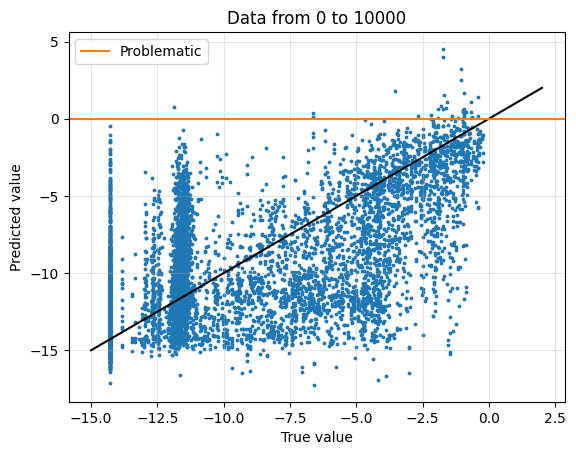

In [189]:
idx1 = 0
idx2 = 10000
plt.scatter(Zg_unscaled[idx1:idx2],
            Zhat_unscaled[idx1:idx2],
            s=3,
)

# Define a range of x-values.
u = np.linspace(-15, 2, 200)
# Set the y-values to be equal to the x-values.
v = u
# Create the plot.
plt.plot(u, v, color='k')
plt.xlabel('True value')
plt.ylabel('Predicted value')

plt.title(f'Data from {idx1} to {idx2}')

plt.axhline(0, label='Problematic', color='tab:orange')
plt.legend()

plt.grid(alpha=0.33)

In [191]:
X.shape

torch.Size([16320, 30, 68])

In [192]:
Yg.shape

(16320, 30)

In [193]:
Yhat.shape

(16320, 30)

Text(0.5, 0, 'Time')

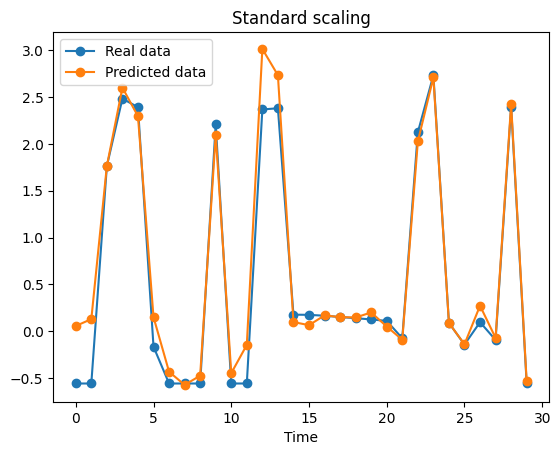

In [200]:
idx = 0
T = range(0,30,1)
plt.plot(T,Yg[idx],
         '-o',
         color='tab:blue',
         label='Real data',
        )
plt.plot(T,Yhat[idx],
         '-o',
         color='tab:orange',
         label='Predicted data'
        )
plt.legend()
plt.title('Standard scaling')
plt.xlabel('Time')

In [201]:
Yg_unscaled.shape

(489600,)

Text(0.5, 0, 'Time')

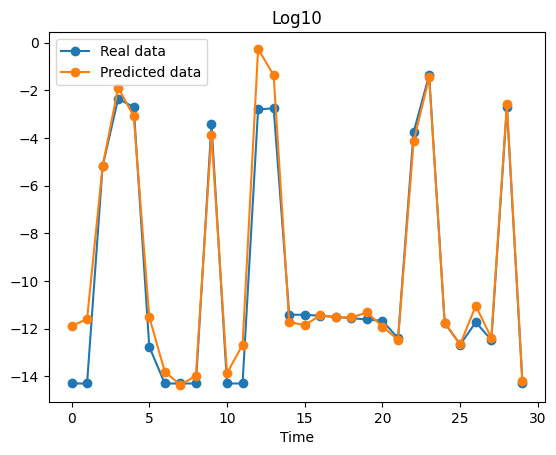

In [203]:
idx = 0
window = 30

T = range(0,30,1)
plt.plot(T,Yg_unscaled[idx*30:(idx+1)*30],
         '-o',
         color='tab:blue',
         label='Real data',
        )
plt.plot(T,Yhat_unscaled[idx*30:(idx+1)*30],
         '-o',
         color='tab:orange',
         label='Predicted data'
        )
plt.legend()
plt.title('Log10')
plt.xlabel('Time')


Text(0.5, 0, 'Time')

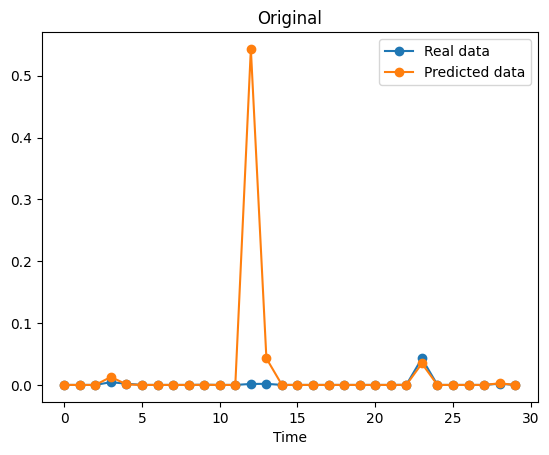

In [204]:
idx = 0
window = 30

T = range(0,30,1)
plt.plot(T,Yg_10[idx*30:(idx+1)*30],
         '-o',
         color='tab:blue',
         label='Real data',
        )
plt.plot(T,Yhat_10[idx*30:(idx+1)*30],
         '-o',
         color='tab:orange',
         label='Predicted data'
        )
plt.legend()
plt.title('Original')
plt.xlabel('Time')

### Binary model

In [84]:
# ==== Model ====
class BinaryLSTM(nn.Module):
    def __init__(self, input_size, 
                 hidden_size=64, 
                 num_layers=1, 
                 dropout=0., 
                 num_heads=4,
                ):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, 
                            hidden_size, 
                            num_layers, 
                            batch_first=True,
                           )
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)
        # self.attn = nn.MultiheadAttention(embed_dim=hidden_size, 
        #                                   num_heads=num_heads, 
        #                                   batch_first=True)
        self.fc2 = nn.Linear(hidden_size, 1)


    def forward(self, x):
        
        x = self.fc1(x)
        
        out, _ = self.lstm(x)
        out = out + x
        
        
        out = self.norm(out)
        out = self.dropout(out)

        # # Apply self-attention: queries, keys, values all = out
        # attn_out, attn_weights = self.attn(out, out, out)  # shapes: same as out
        # out = out + attn_out                               # residual connection
        
        out = self.fc2(out)
        
        return out  # logits (no sigmoid here)

In [103]:
# Compute mean and std over samples AND timesteps for each feature
mean = X.mean(dim=(0, 1), keepdim=True)   # shape: [1,1,num_features]
std = X.std(dim=(0, 1), keepdim=True)     # shape: [1,1,num_features]
W = (Z - mean) / std

In [105]:
bdataset = TensorDataset(W, Z)
bdataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) # must shuffle

In [110]:
num_epochs = 50
num_layers = 1

In [111]:
# ==== Instantiate Model ====
dropout = 0.2
num_heads = 4
input_size = X.shape[2]
model = BinaryLSTM(input_size, 
                   hidden_size=hidden_size, 
                   num_layers=num_layers, 
                   dropout=dropout, 
                   num_heads=num_heads).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# # ✅ Use SGD instead of Adam
# optimizer = torch.optim.SGD(
#     model.parameters(),
#     lr=0.1,           # usually needs to be higher than Adam’s lr
#     momentum=0.9,     # helps stabilize updates
#     weight_decay=1e-4 # optional L2 regularization
# )

print(model)

BinaryLSTM(
  (fc1): Linear(in_features=68, out_features=512, bias=True)
  (lstm): LSTM(512, 512, batch_first=True)
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
)


In [112]:
# ==== Training Loop ====
n_epochs = num_epochs
# max_grad_norm = 1.0  # for gradient clipping
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for xb, yb in bdataloader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits.squeeze(), yb)
        
        loss.backward()
        # Gradient clipping
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

        # for name, param in model.named_parameters():
        #     if param.grad is not None:
        #         grad_mean = param.grad.abs().mean().item()
        #         grad_max = param.grad.abs().max().item()
        #         print(f"{name}: mean_grad={grad_mean:.6f}, max_grad={grad_max:.6f}")

    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch+1}/{n_epochs}  Loss: {avg_loss:.6f}")

Epoch 1/50  Loss: 0.523983
Epoch 2/50  Loss: 0.519386
Epoch 3/50  Loss: 0.517897
Epoch 4/50  Loss: 0.515881
Epoch 5/50  Loss: 0.515639
Epoch 6/50  Loss: 0.514739
Epoch 7/50  Loss: 0.514723
Epoch 8/50  Loss: 0.513402
Epoch 9/50  Loss: 0.514972
Epoch 10/50  Loss: 0.512496
Epoch 11/50  Loss: 0.512741
Epoch 12/50  Loss: 0.510750
Epoch 13/50  Loss: 0.508874
Epoch 14/50  Loss: 0.508578
Epoch 15/50  Loss: 0.506135
Epoch 16/50  Loss: 0.505159
Epoch 17/50  Loss: 0.503115
Epoch 18/50  Loss: 0.499953
Epoch 19/50  Loss: 0.499209
Epoch 20/50  Loss: 0.496942
Epoch 21/50  Loss: 0.497994
Epoch 22/50  Loss: 0.496235
Epoch 23/50  Loss: 0.495429
Epoch 24/50  Loss: 0.493803
Epoch 25/50  Loss: 0.493591
Epoch 26/50  Loss: 0.492865
Epoch 27/50  Loss: 0.492571
Epoch 28/50  Loss: 0.492438
Epoch 29/50  Loss: 0.490410
Epoch 30/50  Loss: 0.490066
Epoch 31/50  Loss: 0.489919
Epoch 32/50  Loss: 0.490012
Epoch 33/50  Loss: 0.493290
Epoch 34/50  Loss: 0.488342
Epoch 35/50  Loss: 0.488912
Epoch 36/50  Loss: 0.487883
E

In [113]:
for name, param in model.named_parameters():
    if param.grad is not None:
        print(name, param.grad.abs().mean(), param.grad.abs().max())


fc1.weight tensor(0.0005, device='cuda:0') tensor(0.7379, device='cuda:0')
fc1.bias tensor(2.3375e-06, device='cuda:0') tensor(7.0501e-05, device='cuda:0')
lstm.weight_ih_l0 tensor(7.8016e-10, device='cuda:0') tensor(8.0034e-06, device='cuda:0')
lstm.weight_hh_l0 tensor(7.5930e-13, device='cuda:0') tensor(8.3605e-09, device='cuda:0')
lstm.bias_ih_l0 tensor(2.9875e-12, device='cuda:0') tensor(1.7229e-09, device='cuda:0')
lstm.bias_hh_l0 tensor(2.9875e-12, device='cuda:0') tensor(1.7229e-09, device='cuda:0')
norm.weight tensor(4.8278e-05, device='cuda:0') tensor(0.0003, device='cuda:0')
norm.bias tensor(0.0005, device='cuda:0') tensor(0.0096, device='cuda:0')
fc2.weight tensor(0.0040, device='cuda:0') tensor(0.0475, device='cuda:0')
fc2.bias tensor(0.0135, device='cuda:0') tensor(0.0135, device='cuda:0')


In [109]:
for name, param in model.named_parameters():
    if param.grad is not None:
        grad_mean = param.grad.abs().mean().item()
        grad_max = param.grad.abs().max().item()
        print(f"{name}: mean_grad={grad_mean:.6f}, max_grad={grad_max:.6f}")

fc1.weight: mean_grad=0.001182, max_grad=1.350934
fc1.bias: mean_grad=0.000005, max_grad=0.000148
lstm.weight_ih_l0: mean_grad=0.000000, max_grad=0.000000
lstm.weight_hh_l0: mean_grad=0.000000, max_grad=0.000000
lstm.bias_ih_l0: mean_grad=0.000000, max_grad=0.000000
lstm.bias_hh_l0: mean_grad=0.000000, max_grad=0.000000
lstm.weight_ih_l1: mean_grad=0.000000, max_grad=0.000000
lstm.weight_hh_l1: mean_grad=0.000000, max_grad=0.000000
lstm.bias_ih_l1: mean_grad=0.000000, max_grad=0.000000
lstm.bias_hh_l1: mean_grad=0.000000, max_grad=0.000000
lstm.weight_ih_l2: mean_grad=0.000000, max_grad=0.000000
lstm.weight_hh_l2: mean_grad=0.000000, max_grad=0.000000
lstm.bias_ih_l2: mean_grad=0.000000, max_grad=0.000000
lstm.bias_hh_l2: mean_grad=0.000000, max_grad=0.000000
norm.weight: mean_grad=0.000116, max_grad=0.000460
norm.bias: mean_grad=0.001439, max_grad=0.023218
fc2.weight: mean_grad=0.014661, max_grad=0.121321
fc2.bias: mean_grad=0.037808, max_grad=0.037808


### Saving models

In [ ]:
# ==== Save Model ====
torch.save(model.state_dict(), "training/lstm_model.pt")
print("✅ Training complete, model saved to training/lstm_model.pt")